# Chapter 01 후반부 MNIST 실례 CNN
* 이부분은 공식 git repo에 있는 code가 있다. 
* https://github.com/PacktPublishing/Mastering-PyTorch/blob/master/Chapter01/mnist_pytorch.ipynb

In [1]:
# import modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
# model architecture 

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1) # 1 input channel, 16 out channel, 3x3 kernel, 1 stride, no padding
        # 그래서 28x28x1인 input image는 26x26x16으로 변한다.
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        # 마찬가지로 26x26x16은 24x24x32로 변한다.
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        # 위 linear층은 평면화된 4608을 64짜리 neural net으로 사영(weigth matrix 크기가 64x4608)
        self.fc2 = nn.Linear(64, 10) # 10x64 weight matrix
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # 풀링은 여기서 정의, 24x24x32인 풀링이 2x2 pooling되면서, 12x12x32로 변함.
        x = self.dp1(x) # 드롭아웃층
        x = torch.flatten(x, 1) #여기가 평면화되는데, 12x12x32=4608층이 되는 부분.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x) #여기가 두번째 드롭아웃층
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1) #마지막 sofmax층
        return op

In [21]:
# training function 
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 100 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [4]:
# model test function
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

In [9]:
MNIST_data_folder = "/home/hyunsu/Documents/data"
training_data = datasets.MNIST(
                    root=MNIST_data_folder, 
                    train=True, 
                    download=True, 
                    transform=transforms.ToTensor()
                    )
testing_data = datasets.MNIST(
                    root=MNIST_data_folder, 
                    train=False, 
                    download=True, 
                    transform=transforms.ToTensor()
                    )

Using downloaded and verified file: /home/hyunsu/Documents/data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting /home/hyunsu/Documents/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/hyunsu/Documents/data/MNIST/raw
Using downloaded and verified file: /home/hyunsu/Documents/data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting /home/hyunsu/Documents/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/hyunsu/Documents/data/MNIST/raw
Using downloaded and verified file: /home/hyunsu/Documents/data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /home/hyunsu/Documents/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/hyunsu/Documents/data/MNIST/raw
Using downloaded and verified file: /home/hyunsu/Documents/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting /home/hyunsu/Documents/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/hyunsu/Documents/data/MNIST/raw
Processing...
Done!


In [11]:
# dataset dataloader, 원 코드에서 normalize를 생략했다. 그래도 되는지 보자. 

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=500, shuffle=False)

In [19]:
# optimizer and device setting
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

model= ConvNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

In [23]:
# training
for epoch in range(1,3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 0.124197
epoch: 1 [3200/60000 (5%)]	 training loss: 0.192158
epoch: 1 [6400/60000 (11%)]	 training loss: 0.004694
epoch: 1 [9600/60000 (16%)]	 training loss: 0.017151
epoch: 1 [12800/60000 (21%)]	 training loss: 0.001104
epoch: 1 [16000/60000 (27%)]	 training loss: 0.001586
epoch: 1 [19200/60000 (32%)]	 training loss: 0.026483
epoch: 1 [22400/60000 (37%)]	 training loss: 0.005940
epoch: 1 [25600/60000 (43%)]	 training loss: 0.002391
epoch: 1 [28800/60000 (48%)]	 training loss: 0.012962
epoch: 1 [32000/60000 (53%)]	 training loss: 0.006721
epoch: 1 [35200/60000 (59%)]	 training loss: 0.005013
epoch: 1 [38400/60000 (64%)]	 training loss: 0.011863
epoch: 1 [41600/60000 (69%)]	 training loss: 0.123858
epoch: 1 [44800/60000 (75%)]	 training loss: 0.105494
epoch: 1 [48000/60000 (80%)]	 training loss: 0.000193
epoch: 1 [51200/60000 (85%)]	 training loss: 0.055303
epoch: 1 [54400/60000 (91%)]	 training loss: 0.002184
epoch: 1 [57600/60000 (96%)]	 trainin

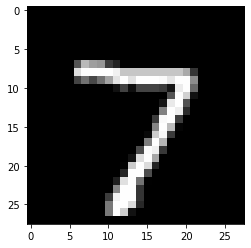

In [24]:
# visulize performance of model
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [27]:
sample_data= torch.tensor(sample_data, device=device)
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}") #armax output of the model
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7


/home/hyunsu/anaconda3/envs/gym/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [46]:
import numpy as np
print(model(sample_data)[0].cpu().detach().numpy()) # data in GPU should be moved in CPU and detach from require_grad by detach
np.argmax(model(sample_data)[0].cpu().detach().numpy(), axis=0)



[-1.9475311e+01 -2.1848099e+01 -1.4551455e+01 -1.4022696e+01
 -2.6649443e+01 -2.3871819e+01 -3.2714928e+01 -1.6689301e-06
 -2.0530622e+01 -1.5024350e+01]


7